In [1]:
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score


In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:_.2f}'.format

In [3]:
data = pd.read_csv('./data.csv')

In [4]:
data

,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,Debt_to_Income,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Loan
0,421802,5.00,10.00,2.00,633_600.00,3.00,0,0,12862,12.55,42_023.25,0,15.39,88.92,3,607_161.90,0.00,19,0,6,17.00,58_598.00,3.00,31_216.05,3,0,0.00,1
1,3964312,3.00,7.00,1.00,85_483.20,4.00,0,0,4177,9.00,38_133.00,0,9.94,102.86,0,269_234.06,0.00,30,1,25,15.00,18_924.00,5.00,11_660.49,3,0,0.00,1
2,4247560,4.00,0.00,1.00,79_200.00,4.00,0,0,36011,24.91,17_100.00,0,22.35,60.37,0,22_476.53,0.00,25,1,9,7.00,15_604.00,5.00,5_637.87,6,0,0.00,1
3,197179,4.00,0.00,2.00,61_600.00,4.00,0,0,2918,16.58,5_130.00,0,10.36,116.27,1,15_242.09,0.00,22,0,31,9.00,22_410.00,3.00,15_607.17,6,0,0.00,0
4,4646684,2.00,2.00,1.00,68_053.92,4.00,0,0,16887,40.05,19_665.00,0,13.68,127.28,1,65_433.94,0.00,32,0,16,10.00,36_022.00,5.00,27_472.86,3,0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87495,4535984,5.00,10.00,0.00,75_680.00,4.00,0,0,10820,19.32,10_260.00,0,8.35,51.08,1,15_100.14,0.00,17,1,19,12.00,32_702.00,3.00,10_012.05,3,0,0.00,1
87496,2624710,3.00,3.00,1.00,90_423.52,4.00,0,0,8465,48.82,27_360.00,0,24.18,129.17,0,102_811.88,0.00,28,1,17,23.00,32_204.00,5.00,24_921.54,3,0,0.00,1
87497,5966919,5.00,10.00,1.00,91_520.00,3.00,0,0,15514,7.80,8_550.00,3,11.03,83.42,1,14_584.11,0.00,16,0,5,8.00,29_050.00,3.00,14_517.90,3,0,0.00,1
87498,2630667,4.00,1.00,1.00,61_600.00,3.00,0,0,21431,8.30,23_769.00,1,22.52,56.76,1,59_281.66,0.00,25,1,36,11.00,24_900.00,3.00,8_454.24,3,0,0.00,1


''

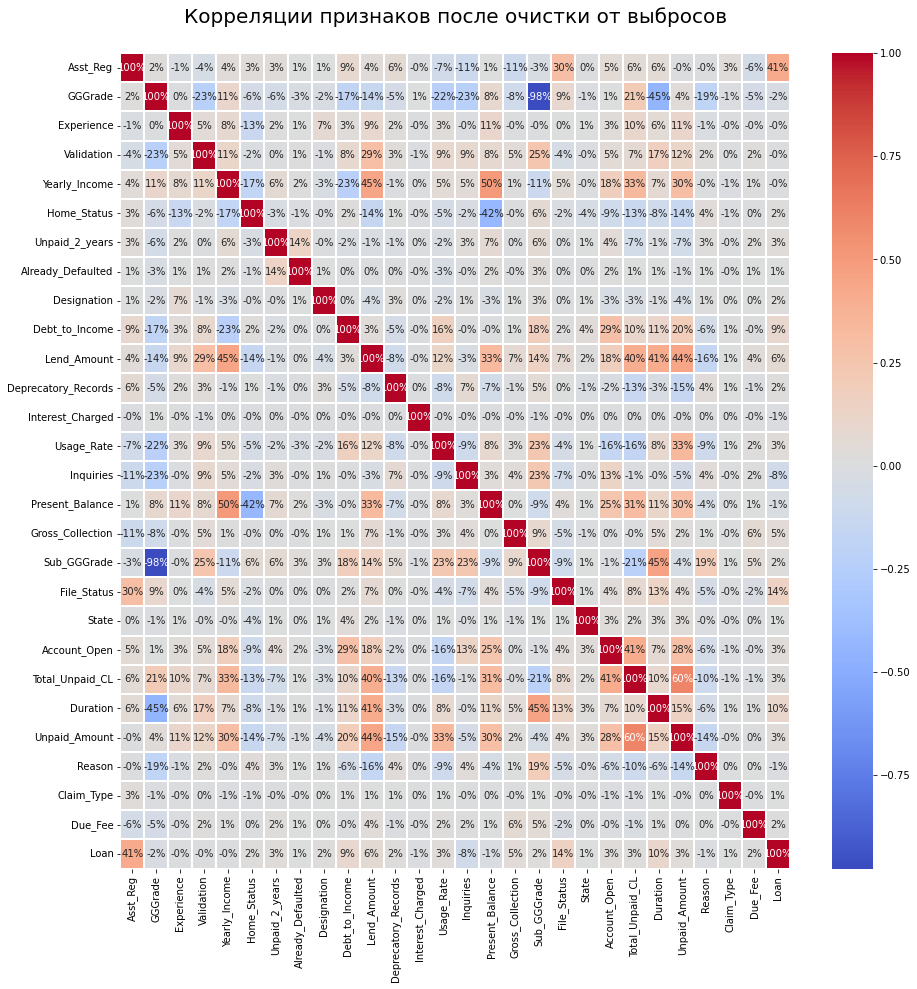

In [5]:
matrix = data.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.DataFrame(matrix), 
            annot=True, 
            fmt='.0%',
            linecolor='white', 
            linewidths=1.5, 
            cmap='coolwarm',
            annot_kws={"fontsize":10}
           )
plt.title('Корреляции признаков после очистки от выбросов', fontsize=20, y=1.03)
;

#### Проверим на отсутствующие значения

In [6]:
data.isnull().any().any()

False

#### Определим размеры обучающей, валидационной и тестовой выборок

In [7]:
train_ratio = 0.8
validation_ratio = 0.1

train_amount = int(train_ratio*data.shape[0])
test_amount = data.shape[0] - train_amount
validation_amount = int(validation_ratio*train_amount)
train_amount -= validation_amount 

print(f'Dataset size    = {data.shape[0]}')
print(f'Train size      = {train_amount}')
print(f'Validation size = {validation_amount}')
print(f'Test size       = {test_amount}')

Dataset size    = 87500
Train size      = 63000
Validation size = 7000
Test size       = 17500


#### Разделим данные на 3 выборки в соответсвии с размерами определёнными выше

In [8]:
# Перемешаем строки в оригинальном наборе данных случайным образом
data = data.sample(frac=1, random_state=5)

# Разделим dataframe на обучающий, валидационный и тестовый используя размеры, найденные на прошлом шаге как индекс
df_train = data.iloc[:train_amount].copy()
df_validation = data.iloc[train_amount:train_amount+validation_amount].copy()
df_test = data.iloc[train_amount+validation_amount:].copy()

#### Собственная реализацией абстрактного класса Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.features = torch.tensor((df.drop(['Loan'], axis=1)).values, dtype=torch.float32)
        self.targets = torch.tensor((df['Loan']).values.reshape(-1,1), dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
    def __len__(self):
        return len(self.features)

In [10]:
train_dataset = CustomDataset(df_train)
val_dataset = CustomDataset(df_validation)
test_dataset = CustomDataset(df_test)

#### Определение констант, используемых в обучении

In [11]:
n_features = train_dataset.features.shape[1] #27
n_outputs = train_dataset.targets.shape[1] #1
BATCH_SIZE = 7000
num_epochs = 120
n_hidden = 108
LR = 0.1

#### Создание объектов класса DataLoader, чтобы передавать в модели батчи

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

#### Функция, принимающая на вход модель и DataLoader, а возвращающая метрики Precision и F1_score

In [13]:
def get_metrics(loader, m):
    m.eval()
    
    true_labels = []
    predicted_labels = []
    
    for features, targets in loader:
        predictions = m.forward(features)
        true_labels += targets.tolist()
        predicted_labels += torch.round(predictions).tolist()
            
    precision = precision_score(true_labels, predicted_labels, zero_division=False)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    m.train()
    return precision, f1

## Построение модели

In [14]:
class LoanClassifier(nn.Module):
    def __init__(self, n_features, hidden_size, n_output):
        super(LoanClassifier, self).__init__()
        
        self.layers = nn.Sequential(
            nn.BatchNorm1d(n_features),
            nn.Linear(n_features, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, n_output),
            nn.Sigmoid()
        )

    def forward(self, x):
        probs = self.layers(x)
        return probs

In [15]:
model = LoanClassifier(n_features, n_hidden, n_outputs)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = MultiStepLR(optimizer, milestones=[1,4,8,12], gamma=0.5)

## Цикл обучения

In [16]:
train_f1_s = []
validation_f1_s = []
loss_s = []

for epoch in range(num_epochs):
    for i, (features, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        predictions = model.forward(features)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        
    train_precision, train_f1 = get_metrics(train_loader, model)
    val_precision, val_f1 = get_metrics(val_loader, model)
    
    train_f1_s.append(train_f1)
    validation_f1_s.append(val_f1)
    loss_s.append(loss.item())
    
    if epoch%10==0:
        print(f'''
        Epoch:{epoch}
        \tLoss = {loss:.2f}
        \tTrain precision      = {train_precision:.2%}
        \tTrain F1_score      = {train_f1:.2%}
        \tValidation precision = {val_precision:.2%}
        \tValidation F1_score = {val_f1:.2%}
        \tLearning rate       = {current_lr:.5f}''')
    


        Epoch:0
        	Loss = 0.59
        	Train precision      = 81.29%
        	Train F1_score      = 73.14%
        	Validation precision = 80.46%
        	Validation F1_score = 71.94%
        	Learning rate       = 0.05000

        Epoch:10
        	Loss = 0.38
        	Train precision      = 81.14%
        	Train F1_score      = 72.71%
        	Validation precision = 80.34%
        	Validation F1_score = 71.58%
        	Learning rate       = 0.01250

        Epoch:20
        	Loss = 0.38
        	Train precision      = 83.04%
        	Train F1_score      = 77.29%
        	Validation precision = 82.39%
        	Validation F1_score = 76.66%
        	Learning rate       = 0.00625

        Epoch:30
        	Loss = 0.37
        	Train precision      = 84.84%
        	Train F1_score      = 80.23%
        	Validation precision = 84.13%
        	Validation F1_score = 79.59%
        	Learning rate       = 0.00625

        Epoch:40
        	Loss = 0.38
        	Train precision      = 85

### Мониторинг метрик качества модели на обучающей, валидационной и тестовой выборках после обучения

In [17]:
train_precision, train_f1 = get_metrics(train_loader, model)
print(f"Train dataset:\n\tPrecision = {train_precision:.2%}\n\tF1_score = {train_f1:.2%}")

val_precision, val_f1 = get_metrics(val_loader, model)
print(f"Validation dataset:\n\tPrecision = {val_precision:.2%}\n\tF1_score = {val_f1:.2%}")

test_precision, test_f1 = get_metrics(test_loader, model)
print(f"Test dataset:\n\tPrecision = {test_precision:.2%}\n\tF1_score = {test_f1:.2%}")

Train dataset:
	Precision = 85.53%
	F1_score = 81.43%
Validation dataset:
	Precision = 84.50%
	F1_score = 80.13%
Test dataset:
	Precision = 85.86%
	F1_score = 81.82%


### Визуализация динамики обучения модели

''

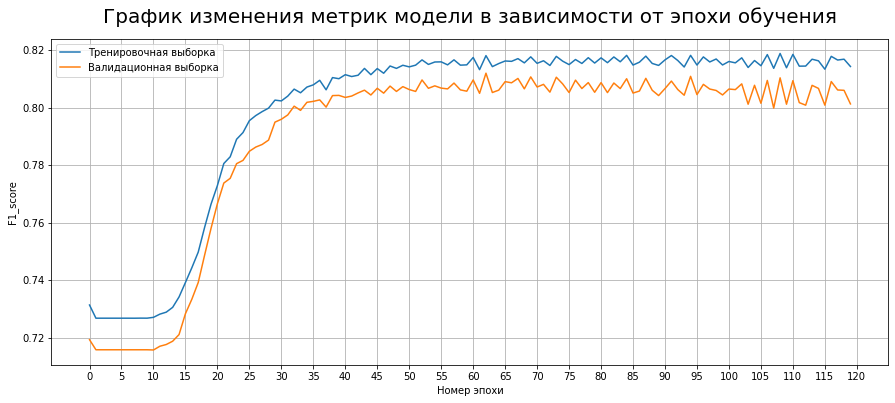

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(train_f1_s, label='Тренировочная выборка')
ax.plot(validation_f1_s, label='Валидационная выборка')
ax.set_xlabel('Номер эпохи')
ax.set_ylabel('F1_score')
ax.set_xticks(range(0,num_epochs+5,5))
ax.grid()
ax.legend()
plt.title('График изменения метрик модели в зависимости от эпохи обучения', fontsize=20, y=1.03)
;

''

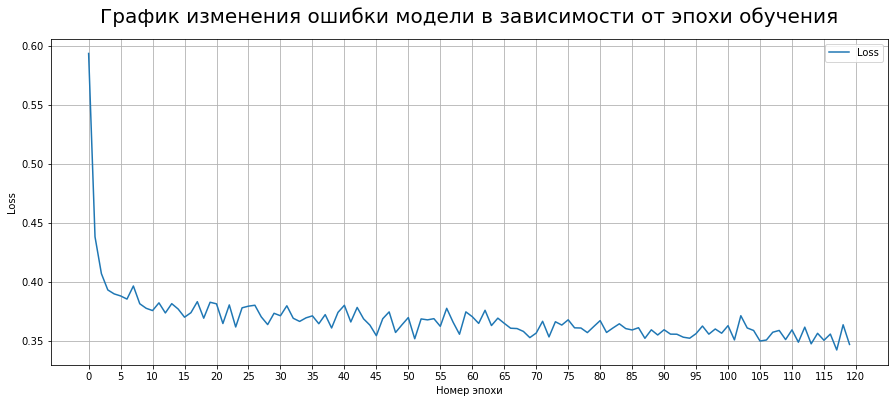

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(loss_s, label='Loss')
ax.set_xlabel('Номер эпохи')
ax.set_ylabel('Loss')
ax.set_xticks(range(0,num_epochs+5,5))
ax.grid()
ax.legend()
plt.title('График изменения ошибки модели в зависимости от эпохи обучения', fontsize=20, y=1.03)
;

#### Наглядная интерпретация результатов работы модели

In [20]:
iterator = iter(test_loader)
batch = next(iterator)
features_example, targets_example = batch
out_example = model(features_example)

df_example = pd.DataFrame({
    'True Loan': targets_example.squeeze(),
    'Positive class probability': out_example.detach().numpy().squeeze(),
    'Predicted class': ((out_example >= 0.5).float()).squeeze()
})
df_example['Positive class probability'] = df_example['Positive class probability'].apply('{:.2%}'.format)

df_example

,True Loan,Positive class probability,Predicted class
0,1.00,88.69%,1.00
1,1.00,98.38%,1.00
2,1.00,99.28%,1.00
3,1.00,84.22%,1.00
4,1.00,88.81%,1.00
5,0.00,18.67%,0.00
6,1.00,98.31%,1.00
7,1.00,93.87%,1.00
8,1.00,19.03%,0.00
9,1.00,98.47%,1.00


In [21]:
pd.concat([
    pd.DataFrame(data=features_example, columns=df_train.drop(columns=['Loan']).columns),
    df_example
],axis=1)

,Asst_Reg,GGGrade,Experience,Validation,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Designation,Debt_to_Income,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,File_Status,State,Account_Open,Total_Unpaid_CL,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,True Loan,Positive class probability,Predicted class
0,3_776_677.00,3.00,10.00,1.00,139_040.00,3.00,0.00,0.00,36_103.00,43.61,41_040.00,0.00,23.36,128.14,2.00,314_093.59,0.00,26.00,1.00,36.00,15.00,61_586.00,5.00,47_237.04,3.00,0.00,0.00,1.00,88.69%,1.00
1,6_596_231.00,6.00,2.00,0.00,131_986.86,5.00,3.00,0.00,8_703.00,27.69,24_624.00,0.00,19.00,63.98,1.00,215_954.38,0.00,13.00,1.00,31.00,12.00,89_640.00,3.00,34_388.10,3.00,0.00,0.00,1.00,98.38%,1.00
2,6_772_997.00,4.00,2.00,2.00,42_944.00,4.00,0.00,0.00,1_049.00,44.64,18_339.75,0.00,20.36,103.72,0.00,18_278.15,0.00,21.00,0.00,6.00,5.00,28_884.00,3.00,22_857.19,2.00,0.00,0.00,1.00,99.28%,1.00
3,3_119_767.00,3.00,8.00,0.00,78_144.00,5.00,0.00,0.00,37_825.00,25.07,15_390.00,0.00,14.99,89.44,1.00,18_486.90,0.00,26.00,0.00,38.00,7.00,12_284.00,3.00,19_263.69,3.00,0.00,0.00,1.00,84.22%,1.00
4,6_478_518.00,4.00,7.00,2.00,123_192.96,3.00,1.00,0.00,2_044.00,23.42,11_970.00,0.00,20.47,55.04,1.00,62_155.73,0.00,21.00,1.00,21.00,17.00,56_772.00,3.00,18_623.61,2.00,0.00,0.00,1.00,88.81%,1.00
5,1_502_862.00,5.00,0.00,1.00,100_672.00,4.00,0.00,0.00,10_591.00,14.31,2_992.50,1.00,13.46,32.16,4.00,38_678.87,0.00,19.00,1.00,31.00,4.00,15_770.00,3.00,3_033.54,2.00,0.00,0.00,0.00,18.67%,0.00
6,7_212_023.00,4.00,3.00,1.00,88_000.00,5.00,0.00,0.00,30_904.00,39.41,27_360.00,0.00,17.24,1.89,0.00,60_423.94,0.00,24.00,1.00,36.00,11.00,24_568.00,3.00,277.02,4.00,0.00,0.00,1.00,98.31%,1.00
7,4_400_729.00,3.00,1.00,0.00,114_400.00,3.00,4.00,0.00,37_439.00,42.29,20_520.00,0.00,22.71,171.66,1.00,318_803.00,0.00,27.00,0.00,13.00,17.00,10_790.00,5.00,11_096.19,3.00,0.00,0.00,1.00,93.87%,1.00
8,1_246_943.00,5.00,10.00,0.00,146_080.00,4.00,0.00,0.00,23_558.00,16.67,8_550.00,0.00,10.46,83.42,1.00,40_781.40,0.00,20.00,1.00,6.00,13.00,28_884.00,3.00,14_427.27,3.00,0.00,0.00,1.00,19.03%,0.00
9,7_033_714.00,2.00,10.00,1.00,82_720.00,3.00,2.00,0.00,18_024.00,41.48,25_650.00,0.00,18.68,115.07,2.00,234_629.98,0.00,33.00,1.00,46.00,19.00,32_868.00,5.00,22_664.34,3.00,0.00,0.00,1.00,98.47%,1.00


## ПОСТРОЕНИЕ АЛЬТЕРНАТИВНЫХ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ

#### Разбиение датасетов на тестовую и обучающие выборки

In [22]:
X_train = df_train.drop('Loan', axis=1).copy()
Y_train = df_train['Loan'].copy()
X_test = df_test.drop('Loan', axis=1).copy()
Y_test = df_test['Loan'].copy()

#### Функция для обучения модели классического машинного обучения

In [23]:
def train_classic_ML(model_architechture):
    current_model = model_architechture
    current_model.fit(X_train, Y_train)
    Y_predictions = current_model.predict(X_test)
    
    precision = precision_score(Y_test, Y_predictions)
    f1 = f1_score(Y_test, Y_predictions)
    
    return precision, f1

### Логистическая регрессия (Logistic Regression) 

In [24]:
LogReg_precision, LogReg_f1 = train_classic_ML(LogisticRegression(solver='liblinear'))
print(f'Logistic Regression:\n\tPrecision = {LogReg_precision:.2%}\n\tF1_score = {LogReg_f1:.2%}')

Logistic Regression:
	Precision = 83.07%
	F1_score = 90.23%


### Случайный лес (Random Forest) 

In [25]:
RandomForest_precision, RandomForest_f1 = train_classic_ML(RandomForestClassifier(n_estimators=100))
print(f'Random Forest:\n\tPrecision = {RandomForest_precision:.2%}\n\tF1_score = {RandomForest_f1:.2%}')

Random Forest:
	Precision = 85.49%
	F1_score = 91.01%


### Градиентный бустинг (Gradient Boosting) 

In [26]:
GBC_precision, GBC_f1 = train_classic_ML(GradientBoostingClassifier())
print(f'Gradient Boosting Classifier:\n\tPrecision = {GBC_precision:.2%}\n\tF1_score = {GBC_f1:.2%}')

Gradient Boosting Classifier:
	Precision = 85.60%
	F1_score = 91.08%


### Сравнение результатов

In [27]:
df_res_s = pd.DataFrame(
    index=['Precision', 'F1_score'],
    columns=['CustomNeuralNetwork', 'LogisticRegression', 'RandomForest', 'GradientBoosting']
)
df_res_s.loc['Precision', 'CustomNeuralNetwork'] = test_precision
df_res_s.loc['F1_score', 'CustomNeuralNetwork'] = test_f1

df_res_s.loc['Precision', 'LogisticRegression'] = LogReg_precision
df_res_s.loc['F1_score', 'LogisticRegression'] = LogReg_f1

df_res_s.loc['Precision', 'RandomForest'] = RandomForest_precision
df_res_s.loc['F1_score', 'RandomForest'] = RandomForest_f1

df_res_s.loc['Precision', 'GradientBoosting'] = GBC_precision
df_res_s.loc['F1_score', 'GradientBoosting'] = GBC_f1

In [28]:
df_res_s.style.format('{:.2%}')

,CustomNeuralNetwork,LogisticRegression,RandomForest,GradientBoosting
Precision,85.86%,83.07%,85.49%,85.60%
F1_score,81.82%,90.23%,91.01%,91.08%


Исходя из того, что в моей задаче крайне **важно** точно предсказывать **отрицательный** класс **(неплатежеспособных людей)**, **Precision** играет более важную роль, чем Recall, так как лучше отказать надежному заемщику, чем выдать кредит ненадежному. Поэтому, на основе таблицы, мы можем сделать вывод, что моя нейронная сеть имеет **наилучший Precision** среди всех моделей, включая модели классического машинного обучения, а это значит, что она **качественнее выделит неплатёжеспособных** людей.